In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import re
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
stops = set(stopwords.words('english'))
from nltk.stem.porter import PorterStemmer
p_stemmer = PorterStemmer()
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV 
%matplotlib inline

In [2]:
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [5]:
df=pd.read_csv('LibCon03-06-2018.csv')

df.shape

(3842, 18)

In [6]:
df['sent_label'] = 'neutral'
df.loc[df['sentiment'] > 0.1, 'sent_label'] = 'positive'
df.loc[df['sentiment'] < -0.1, 'sent_label'] = 'negative'
df.head(3)
    

,body,comms_num,created,domain,id,score,subreddit,time_retrieved,title,time,time_retrieved.1,post_duration,time_hm,day,word_count,sent_sia,sentiment,subjectivity,sent_label
0,NaN,1,1.527722e+09,medium.com,8n9e7d,1,Conservative,2018-05-30 22:07:10.938189+00:00,The Day I Learned We Had a Fake News Problem,2018-05-30 23:17:28.000000,2018-05-30 22:07:10.938189,23.0,23,Sun,10,-0.38,-0.50,1.00,negative
1,NaN,0,1.527281e+09,medium.com,8m1ean,8,Conservative,2018-05-30 22:07:10.938189+00:00,Jordan Peterson LBC Interview: A Few Highlights,2018-05-25 20:35:45.000000,2018-05-30 22:07:10.938189,2.0,20,Sun,7,-0.48,-0.20,0.10,negative
2,NaN,0,1.527121e+09,thefederalist.com,8lko53,7,Conservative,2018-05-30 22:07:10.938189+00:00,James Clapper Just Lied Again About His Previo...,2018-05-24 00:21:14.000000,2018-05-30 22:07:10.938189,22.0,0,Sun,12,0.59,-0.17,0.17,negative


In [7]:
df_Lib=df[df['subreddit']=='Liberal'] 
df_Con=df[df['subreddit']=='Conservative']

In [8]:
Lib_news= df_Lib['domain'].value_counts().head(15).index.tolist() 
Con_news= df_Con['domain'].value_counts().head(15).index.tolist() 

# df['domain_d'] = [type_ if type_ in DD
#                       else "OTHER" for type_ in df['domain']]

# df['domain_d'].value_counts()
News_Comm=list(set(Con_news+Lib_news))
df['domain_d'] = [type_ if type_ in News_Comm
                      else "OTHER" for type_ in df['domain']]

df['domain_d'].value_counts()

OTHER                   1813
i.redd.it                245
i.imgur.com              153
dailywire.com            132
foxnews.com              103
thehill.com               98
self.Liberal              88
washingtonpost.com        85
thinkprogress.org         77
nytimes.com               77
rawstory.com              67
theguardian.com           66
thegatewaypundit.com      63
breitbart.com             61
huffingtonpost.com        61
politico.com              58
pluralist.com             58
nationalreview.com        56
thefederalist.com         56
salon.com                 51
dailycaller.com           50
alternet.org              45
vox.com                   42
nypost.com                40
self.Conservative         37
imgur.com                 37
cnn.com                   35
newsbusters.org           31
hotair.com                29
prospect.org              28
Name: domain_d, dtype: int64

In [9]:
cat_features = df.select_dtypes(include = ["object"]).columns
num_features = df.select_dtypes(exclude = ["object"]).columns
df_num = df[num_features]
df_cat = df[cat_features]
print("Numerical features : " + str(len(num_features)))
print(df.select_dtypes(exclude=['O']).columns.values)
print("Categorical features : " + str(len(cat_features)))
print((df.select_dtypes(include=['O']).columns.values))
# train_num = train[numerical_features]
# train_cat = train[categorical_features]

Numerical features : 9
['comms_num' 'created' 'score' 'post_duration' 'time_hm' 'word_count'
 'sent_sia' 'sentiment' 'subjectivity']
Categorical features : 11
['body' 'domain' 'id' 'subreddit' 'time_retrieved' 'title' 'time'
 'time_retrieved.1' 'day' 'sent_label' 'domain_d']


In [10]:
print('Scores')
print("Mean is {:0.2f} and the Median is {:0.2f}".format(np.mean(df.score),np.median(df.score)))
print('Number of coments')
print("Mean is {:0.2f} and the Median is {:0.2f}".format(np.mean(df.comms_num),np.median(df.comms_num)))



Scores
Mean is 487.85 and the Median is 147.00
Number of coments
Mean is 79.30 and the Median is 14.00


### NLP

In [11]:
df['text']=df['title'].str.replace('\d+', '')
# df_lib_con.title = df_lib_con.title.str.replace('\d+', '')

In [12]:
def process_lem(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    tokens = word_tokenize(text)
    
    lemmer = WordNetLemmatizer()
    stop_words = stopwords.words("english")
    return ' '.join([lemmer.lemmatize(word) for word in tokens if not word in stop_words])

In [13]:
df['text'] = [process_lem(text) for text in df['text']]

In [14]:

le=LabelEncoder()
# X = df['domain_d']
X = df[['word_count','sentiment','domain_d','title','post_duration','text']]
# y=df_combined['subreddit']
# transform the label 
y = le.fit_transform(df['subreddit'])
# y_cm = LabelEncoder().fit_transform(df['comments_label'])

In [15]:
df.subreddit.value_counts()

Conservative    2184
Liberal         1658
Name: subreddit, dtype: int64

In [16]:
y.sum()

1658

In [17]:
X_d = pd.get_dummies(X, columns=['domain_d'], drop_first=True)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_d, y, test_size=0.5, random_state=42)


In [19]:
tvec = TfidfVectorizer(stop_words=stopwords.words('english'),
                                 lowercase=True,max_features=500)

X_train_matrix = tvec.fit_transform(X_train['text'])
X_test_matrix = tvec.transform(X_test['text'])

In [47]:
X_train_df = pd.DataFrame(X_train_matrix.todense(),
                         columns=tvec.get_feature_names(),
                         index=X_train.index)

In [48]:
X_test_df = pd.DataFrame(X_test_matrix.todense(),
                        columns=tvec.get_feature_names(),
                        index=X_test.index)

In [50]:
X_train_all = pd.concat([X_train_df, X_train.drop('title', axis=1)], axis=1)
X_test_all = pd.concat([X_test_df, X_test.drop('title', axis=1)], axis=1)

In [20]:
forest = RandomForestClassifier(max_depth=10, n_estimators=5)
lr=LogisticRegression()

In [21]:
lr.fit(X_train_matrix, y_train)
print('Log Reg')
print(lr.score(X_train_matrix, y_train))
print(lr.score(X_test_matrix, y_test))

forest.fit(X_train_matrix, y_train)
print('\n Random Forest')
print(forest.score(X_train_matrix, y_train))
print(forest.score(X_test_matrix, y_test))

Log Reg
0.7813638729828214
0.6637168141592921

 Random Forest
0.6782925559604372
0.6241540864133264


In [52]:
print((X_train_all.select_dtypes(include=['O']).columns.values))

['text']


In [54]:
X_train_all=X_train_all.drop('text',axis=1)
X_test_all=X_test_all.drop('text',axis=1)

In [55]:
lr.fit(X_train_all, y_train)
print('Log Reg')
print(lr.score(X_train_all, y_train))
print(lr.score(X_test_all, y_test))

forest.fit(X_train_all, y_train)
print('\n Random Forest')
print(forest.score(X_train_all, y_train))
print(forest.score(X_test_all, y_test))

Log Reg
0.8974492451847996
0.8157209786569495

 Random Forest
0.7506507027589797
0.7001561686621551


In [ ]:
from tpot import TPOTClassifier

tpot=TPOTClassifier()

tpot = TPOTClassifier(generations=3, population_size=20, verbosity=2)
tpot.fit(X_train_all, y_train)
print(tpot.score(X_test_all, y_test))
tpot.export('tpot_pipeline.py')

In [ ]:
X_d.shape

In [ ]:
# so we choose log reg


## Predict on pol


In [22]:
df_pol=pd.read_csv('Pol03-06-2018.csv')

df_pol.shape

(3382, 18)

### NLP

In [24]:
df_pol['text']=df_pol['title'].str.replace('\d+', '')
# df_lib_con.title = df_lib_con.title.str.replace('\d+', '')

In [25]:
df_pol['text'] = [process_lem(text) for text in df_pol['text']]

In [30]:
DD_p= df_pol['domain'].value_counts().head(29).index.tolist()


# df['domain_d'] = [type_ if type_ in News_Comm
#                       else "OTHER" for type_ in df['domain']]
df_pol['domain_d'] = [type_ if type_ in DD_p
                      else "OTHER" for type_ in df_pol['domain']]
print(df_pol['domain_d'].nunique())
print(df['domain_d'].nunique())

30
30


In [31]:
df_pol_t = df_pol[['word_count','sentiment','domain_d','title','post_duration','text']]
# X_n=df[['word_count','sentiment','subjectivity','domain','title','post_duration']]
# y=df_combined['subreddit']
# transform the label 
# y = LabelEncoder().fit_transform(df['subreddit'])
# y_cm = LabelEncoder().fit_transform(df['comments_label'])

In [32]:
df_pol_matrix = tvec.transform(df_pol_t['text'])

In [34]:
df_pol_matrix_df = pd.DataFrame(df_pol_matrix.todense(),
                         columns=tvec.get_feature_names(),
                         index=df_pol_t.index)

In [35]:
df_pol_t = pd.concat([df_pol_matrix_df, df_pol_t.drop('title', axis=1)], axis=1)
# X_test_all = pd.concat([X_test_df, X_test.drop('title', axis=1)], axis=1)

In [37]:
print('Scores')
print("Mean is {:0.2f} and the Median is {:0.2f}".format(np.mean(df.score),np.median(df.score)))
print('Number of coments')
print("Mean is {:0.2f} and the Median is {:0.2f}".format(np.mean(df.comms_num),np.median(df.comms_num)))



Scores
Mean is 487.85 and the Median is 147.00
Number of coments
Mean is 79.30 and the Median is 14.00


In [36]:
df_pol_t.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3382 entries, 0 to 3381
Columns: 505 entries, abortion to text
dtypes: float64(502), int64(1), object(2)
memory usage: 13.0+ MB


In [38]:
df_pol_d=pd.get_dummies(df_pol_t, columns=['domain_d'], drop_first=True)

In [40]:
print((df_pol_d.select_dtypes(include=['O']).columns.values))

['text']


In [46]:
X_d.shape

(3842, 34)

In [44]:
df_pol_d.shape

(3382, 532)

In [42]:
df_pol_d=df_pol_d.drop('text',axis=1)

In [56]:
y_hat = lr.predict(df_pol_d)

df_pol['y_hats'] = y_hat

In [57]:
df_pol['pol_id']= le.inverse_transform(df_pol['y_hats'])

/Users/admin/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [ ]:
df_pol.head(3)

In [ ]:
df_pol.pol_id.value_counts()

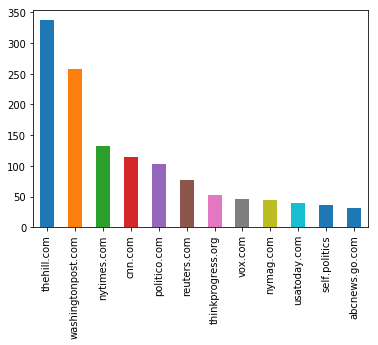

In [58]:
df_pol[df_pol['pol_id']=='Liberal']['domain'].value_counts().head(12).plot(kind='bar');

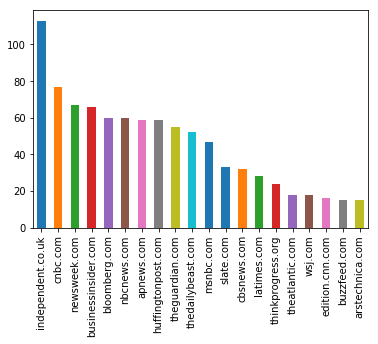

In [61]:
df_pol[df_pol['pol_id']=='Conservative']['domain'].value_counts().head(20).plot(kind='bar');

In [ ]:
df_pol[(df_pol['domain'] == 'nationalreview.com' )]

In [ ]:
df_pol.sample(10)